FF++ provided mask videos for the dataset.

First, utilize provided masks to reduce the overall dataset image size.

Then, run cropped dataset on neural network based detector to get rid of frames without face to increase dataset quality.

In [1]:
import sys
if '../../' not in sys.path:
    sys.path.append('../../')
from Utils.FileOperation import *
from Config import rootDir

import numpy as np
from PIL import Image
import time
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from batch_face import RetinaFace
import statistics
import math

In [2]:
def calculate_mean_frame_count(video_paths):
    frame_counts = []

    for path in video_paths:
        cap = cv2.VideoCapture(path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_counts.append(frame_count)
        cap.release()

    mean_frame_count = statistics.mean(frame_counts)
    median_frame_count = statistics.median(frame_counts)
    max_frame_count = max(frame_counts)
    min_frame_count = min(frame_counts)

    return mean_frame_count, median_frame_count, max_frame_count, min_frame_count, frame_counts

def get_frame_ranges(frame_counts, bar_width):
    frame_ranges = []
    for frame_count in frame_counts:
        frame_range = (frame_count // bar_width) * bar_width
        frame_ranges.append(frame_range)
    return frame_ranges

Mean frame count: 509.128
Median frame count: 457.5
Maximum frame count: 1814
Minimum frame count: 287


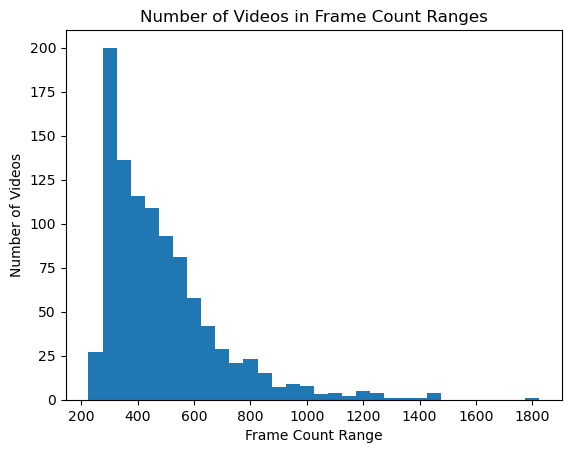

In [3]:
realDir = rootDir + 'FF++/c23/real/'
# Find length distribution of data
video_paths = [realDir + i for i in ls(realDir)]
mean_frames, median_frames, max_frames, min_frames, frame_counts = calculate_mean_frame_count(video_paths)
print(f"Mean frame count: {mean_frames}")
print(f"Median frame count: {median_frames}")
print(f"Maximum frame count: {max_frames}")
print(f"Minimum frame count: {min_frames}")

# Define the bar width for frame ranges
bar_width = 50

# Get the frame ranges for each video
frame_ranges = get_frame_ranges(frame_counts, bar_width)

# Count the number of videos in each frame range
frame_ranges_counter = Counter(frame_ranges)

# Prepare the data for plotting
x_values = list(frame_ranges_counter.keys())
y_values = list(frame_ranges_counter.values())

# Plotting the bar chart
plt.bar(x_values, y_values, width=bar_width)
plt.xlabel('Frame Count Range')
plt.ylabel('Number of Videos')
plt.title('Number of Videos in Frame Count Ranges')
plt.show()

In [3]:
def extract(
        mask_path,
        data_path,
        output_path,
        padding=0,
        center_tweaks=(0,0),
        smooth_level=0
    ):
    '''
    Parameters:
        mask_path: Path to the mask video
        data_path: Path to the original video
        output_path: Path to the output video
        padding: Number of pixels to add as margin to the original bounding box
        center_tweaks: Tweaks to the center of the bounding box
        smooth_level: Number of frames to smooth the bounding box
    '''
    # Task 1: Load mask video
    mask_video = cv2.VideoCapture(mask_path)

    # Task 2: Find bounding box for each frame in the mask video
    bounding_boxes = []
    max_w, max_h = 0, 0
    while mask_video.isOpened():
        success, frame = mask_video.read()
        if not success:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray_frame, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            # Find the largest contour (assumed to be the face shape)
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            center = (x + w // 2, y + h // 2)
            center = (center[0] + center_tweaks[0], center[1] + center_tweaks[1])

            # Adjust bounding box aspect ratio
            aspect_ratio = 1.0
            h = max(int((w + 2 * padding) * aspect_ratio), h + 2 * padding)
            w = int(h // aspect_ratio)
            x, y = int(center[0] - w // 2), int(center[1] - h // 2)

            max_w, max_h = max(max_w, w), max(max_h, h)

            bounding_boxes.append((x, y, x+w, y+h))
        else:
            # Set bounding box to (0, 0, 0, 0) when no contour is detected (pure black frame)
            print('\nNo bounding box found at frame', len(bounding_boxes))
            bounding_boxes.append((0, 0, 0, 0))

    mask_video.release()
    max_h = max(max_h, int(max_w * aspect_ratio))
    max_w = max(max_w, int(max_h // aspect_ratio))

    # Task 3: Load original video
    original_video = cv2.VideoCapture(data_path)

    # Task 4: Crop original video frames using the mask's bounding boxes with PIL.Image
    cropped_frames = []

    for idx in range(len(bounding_boxes)):
        success, frame = original_video.read()
        if not success:
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if bounding_boxes[idx] != (0, 0, 0, 0):
            # Smooth bounding boxes
            id_0 = max(0, idx - smooth_level // 2)
            id_1 = min(len(bounding_boxes), idx + 1 + math.ceil(smooth_level / 2))
            curr_bounding_box = smooth_frames(bounding_boxes[id_0:id_1])
            
            cropped_frame = Image.fromarray(frame).crop(curr_bounding_box)
            cropped_frames.append(cropped_frame)

    # Task 5: Resize cropped frames and save as a video
    output_size = (max_w, max_h)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, output_size)

    for frame in cropped_frames:
        resized_frame = frame.resize(output_size)
        out.write(cv2.cvtColor(np.array(resized_frame), cv2.COLOR_RGB2BGR))

    out.release()


def smooth_frames(bounding_boxes):
    '''
    Smooth bounding boxes using linear interpolation
    Parameters:
        bounding_boxes: List of bounding boxes, length of list means smooth level
    Return:
        One smoothed bounding box
    '''

    # Filter out (0, 0, 0, 0) bounding boxes
    filtered_boxes = [box for box in bounding_boxes if box != (0, 0, 0, 0)]
    
    if len(filtered_boxes) == 0:
        return (0, 0, 0, 0)

    # Linear interpolation of bounding boxes
    x0, y0, x1, y1 = 0, 0, 0, 0
    for bounding_box in filtered_boxes:
        x0 += bounding_box[0]
        y0 += bounding_box[1]
        x1 += bounding_box[2]
        y1 += bounding_box[3]

    x0, y0, x1, y1 = int(x0 / len(filtered_boxes)), int(y0 / len(filtered_boxes)), int(x1 / len(filtered_boxes)), int(y1 / len(filtered_boxes))
    return (x0, y0, x1, y1)

In [4]:
def detect(
        detector,
        vidDir,
        batch_size=400
    ):
    '''
    Detect faces in the video and delete frames without faces detected
    Parameters:
        detector: Face detector
        vidDir: Path to the video directory
        batch_size: Number of frames processed by the detector at a time
    Video Types:
        abandoned: You won't see it in its original path,
            it will be moved into the abandoned folder without any editing
        troublesome: You will see its edited version in its original path,
            and the original version in the troublesome folder
        low_quality: You won't see its edited version in its original path,
            it will be moved into the low_quality folder without any editing
    '''
    # Load video
    out = cv2.VideoCapture(vidDir)
    
    # Load frames
    frames = []
    while out.isOpened():
        success, frame = out.read()
        if not success:
            break
        frames.append(frame)
    out.release()
    
    # Detect faces
    emptyFrameIndices = []
    all_faces = []
    for i in range(math.ceil(len(frames)/batch_size)):
        all_faces.extend(detector(frames[i*batch_size:(i+1)*batch_size]))
    for i, face_info in enumerate(all_faces):
        empty = True
        for box, landmarks, score in face_info:
            # Score > 0.95 and bbox area > 40% of the frame
            if score > 0.95 and (box[2] - box[0]) * (box[3] - box[1]) > frames[i].shape[0] * frames[i].shape[1] * 0.4:
                empty = False
                break
        if empty:
            emptyFrameIndices.append(i)
    
    if len(emptyFrameIndices) == 0:
        return
    
    print('\n * ' + str(len(emptyFrameIndices)) + ' Empty frames detected')

    if len(frames) - len(emptyFrameIndices) < 56:
        print(' >> Too few frames left, deleted')
        make_backup(vidDir, 'abandoned')
        rm(vidDir)
        return

    low_quality = False
    if len(emptyFrameIndices) > 0.5 * len(frames):
        print(' >> Low quality video')
        low_quality = True
    
    # Delete frames without faces detected
    for i in emptyFrameIndices[::-1]:
        '''
        # Show the frame
        frame = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame).resize((int(frame.shape[1] / 2), int(frame.shape[0] / 2)))
        frame.show()
        '''
        del frames[i]
    
    # Make backup of the original video
    make_backup(vidDir, 'troublesome')
    
    # Write frames to video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    if low_quality:
        original_vidDir = vidDir
        vidDir = make_backup(vidDir, 'low_quality')
    out = cv2.VideoWriter(vidDir, fourcc, 30, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        out.write(frame)
    out.release()
    if low_quality:
        rm(original_vidDir)

def make_backup(vidDir, backup_dir='backup'):
    output_path_elements = vidDir.split('/')
    last_len = len(output_path_elements[-1])
    output_path_elements[-1] = backup_dir + '/' + output_path_elements[-1]
    output_path = '/'.join(output_path_elements)
    mkdir(output_path[:-last_len])
    cp(vidDir, output_path)
    return output_path

**NOTICE**

227 is in test set, but it will be moved into abandoned folder due to its broken manipulation

Please move it to its original position manually

In [6]:
dataDirs = [
    rootDir + 'FF++/c23/fake/Deepfakes/',
    rootDir + 'FF++/c23/fake/Face2Face/',
    rootDir + 'FF++/c23/fake/FaceSwap/',
    rootDir + 'FF++/c23/fake/NeuralTextures/',
]
detector = RetinaFace(gpu_id=0)
paddings = [17, 10, 10, 10] # Number of pixels to pad on each manipulating method
center_tweaks = [(0,0),(0,0),(0,10),(0,-5)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [5, 3, 3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c23/fake', 'masks')
    saveDir = dataDir.replace('FF++', 'cropped_videos/FF++_crop/c23/')
    vidDirs = ls(dataDir)
    savedList = ls(saveDir)
    for vidDir in vidDirs:
        if vidDir in savedList:
            saved = cv2.VideoCapture(saveDir + vidDir)
            saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
            saved.release()
            original = cv2.VideoCapture(dataDir + vidDir)
            original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
            original.release()
            if saved_frame_count == original_frame_count:
                continue
        print('\r' + time.ctime(time.time()), ':', dataDir + vidDir + '             ', end='')
        try:
            extract(
                maskDir + vidDir,
                dataDir + vidDir,
                saveDir + vidDir,
                padding,
                center_tweak,
                smooth_level
            )
            detect(detector, saveDir + vidDir)
        except:
            print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")
realDir = rootDir + 'FF++/c23/real/'
dataDir = realDir
maskDir = dataDirs[0].replace('c23/fake', 'masks') # Real videos can share the same masks with Deepfakes
saveDir = realDir.replace('FF++', 'cropped_videos/FF++_crop/c23/')
vidDirs = ls(dataDir)
savedList = ls(saveDir)
maskVidDirs = ls(maskDir)
for vidDir, maskVidDir in zip(vidDirs, maskVidDirs):
    if vidDir in savedList:
        saved = cv2.VideoCapture(saveDir + vidDir)
        saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
        saved.release()
        original = cv2.VideoCapture(dataDir + vidDir)
        original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
        original.release()
        if saved_frame_count == original_frame_count:
            continue
    print('\r' + time.ctime(time.time()), ':', dataDir + vidDir + '             ', end='')
    try:
        extract(
            maskDir + maskVidDir,
            dataDir + vidDir,
            saveDir + vidDir,
            paddings[0],
            center_tweaks[0],
            smooth_levels[0]
        )
        detect(detector, saveDir + vidDir)
    except:
        print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")

Mon Jul 17 20:04:15 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/024_073.mp4             
No bounding box found at frame 225

No bounding box found at frame 226
Mon Jul 17 20:04:17 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/128_896.mp4             
 * 4 Empty frames detected
Mon Jul 17 20:04:19 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/163_031.mp4             
 * 2 Empty frames detected
Mon Jul 17 20:04:21 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/212_179.mp4             
 * 2 Empty frames detected
Mon Jul 17 20:04:23 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/305_513.mp4             
 * 75 Empty frames detected
Mon Jul 17 20:04:29 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/365_307.mp4             
 * 41 Empty frames detected
Mon Jul 17 20:04:30 2023 : /home/kyr/GazeForensicsData/FF++/fake/Deepfakes/c23/videos/370_483.mp4             
No bounding box

In [8]:
dataDirs = [
    rootDir + 'FF++/c40/fake/Deepfakes/',
    rootDir + 'FF++/c40/fake/Face2Face/',
    rootDir + 'FF++/c40/fake/FaceSwap/',
    rootDir + 'FF++/c40/fake/NeuralTextures/',
]
detector = RetinaFace(gpu_id=0)
paddings = [17, 10, 10, 10] # Number of pixels to pad on each manipulating method
center_tweaks = [(0,0),(0,0),(0,10),(0,-5)] # (x,y) tweaks to the center of the face corresponding to the methods
smooth_levels = [5, 3, 3, 3] # Level of smoothing to apply to the mask corresponding to the methods
for dataDir, padding, center_tweak, smooth_level in zip(dataDirs, paddings, center_tweaks, smooth_levels):
    maskDir = dataDir.replace('c40/fake', 'masks')
    saveDir = dataDir.replace('FF++', 'cropped_videos/FF++_crop/')
    vidDirs = ls(dataDir)
    savedList = ls(saveDir)
    for vidDir in vidDirs:
        if vidDir in savedList:
            saved = cv2.VideoCapture(saveDir + vidDir)
            saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
            saved.release()
            original = cv2.VideoCapture(dataDir + vidDir)
            original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
            original.release()
            if saved_frame_count == original_frame_count:
                continue
        print('\r' + time.ctime(time.time()), ':', dataDir + vidDir + '             ', end='')
        try:
            extract(
                maskDir + vidDir,
                dataDir + vidDir,
                saveDir + vidDir,
                padding,
                center_tweak,
                smooth_level
            )
            detect(detector, saveDir + vidDir)
        except:
            print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")
realDir = rootDir + 'FF++/c40/real/'
dataDir = realDir
maskDir = dataDirs[0].replace('c40/fake', 'masks') # Real videos can share the same masks with Deepfakes
saveDir = realDir.replace('FF++', 'cropped_videos/FF++_crop/')
vidDirs = ls(dataDir)
savedList = ls(saveDir)
maskVidDirs = ls(maskDir)
for vidDir, maskVidDir in zip(vidDirs, maskVidDirs):
    if vidDir in savedList:
        saved = cv2.VideoCapture(saveDir + vidDir)
        saved_frame_count = int(saved.get(cv2.CAP_PROP_FRAME_COUNT))
        saved.release()
        original = cv2.VideoCapture(dataDir + vidDir)
        original_frame_count = int(original.get(cv2.CAP_PROP_FRAME_COUNT))
        original.release()
        if saved_frame_count == original_frame_count:
            continue
    print('\r' + time.ctime(time.time()), ':', dataDir + vidDir + '             ', end='')
    try:
        extract(
            maskDir + maskVidDir,
            dataDir + vidDir,
            saveDir + vidDir,
            paddings[0],
            center_tweaks[0],
            smooth_levels[0]
        )
        detect(detector, saveDir + vidDir)
    except:
        print("\n>>>>>>>>>> ERROR OCCURED <<<<<<<<<<")

Sat Aug  5 23:46:19 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/020_344.mp4             
 * 4 Empty frames detected
Sat Aug  5 23:46:26 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/024_073.mp4             
No bounding box found at frame 225

No bounding box found at frame 226
Sat Aug  5 23:48:45 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/085_124.mp4             
 * 5 Empty frames detected
Sat Aug  5 23:49:40 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/108_052.mp4             
 * 7 Empty frames detected
Sat Aug  5 23:49:49 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/112_892.mp4             
 * 3 Empty frames detected
Sat Aug  5 23:50:36 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/128_896.mp4             
 * 25 Empty frames detected
Sat Aug  5 23:51:20 2023 : /home/kyr/GazeForensicsData/FF++/c40/fake/Deepfakes/151_225.mp4             
 * 1 Empty frames detected
Sat Aug  5 23:51:45 2023 : /home/kyr/G